In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [2]:
n = 128
m = 64
sigma = 0.1
p = 0.05
num_itr = 40

K = 200
adam_lr = 5e-5
max_inner = 20

A = np.random.randn(m, n)
eig, _ = LA.eig(A.T @ A)
gamma_opt = float(1./max(eig).real)
A = jnp.array(A)

In [3]:
def mini_batch(K):
    seq = np.random.randn(n, K)
    support = np.random.binomial(1,p,size=(n, K))
    x = jnp.array(seq * support)
    y = A @ x + sigma * jnp.array(np.random.randn(m, K))
    return y, x

In [4]:
def softshrink(x, lam):
    return jnp.sign(x) * jnp.max(jnp.append(jnp.abs(x) - lam, 0))
vec_softshrink = jax.jit(jax.vmap(softshrink, in_axes=[-1, None], out_axes=-1))

In [5]:
def ISTA(max_itr, y):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= gamma_opt * A.T @ (A@x - y)
        x = vec_softshrink(x.reshape(1, -1), gamma_opt)
        x = x.reshape(n, K)
    return x

In [6]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [7]:
def comp_mse(max_itr):
    y, x_org = mini_batch(K)
    x_hat = ISTA(max_itr, y)
    return jnp.sum(batch_get_dot(x_org - x_hat))/K

In [8]:
ISTA_mse = [float(jax.device_get(comp_mse(i+1)).real) for i in range(num_itr)]
df = pd.DataFrame()
df["Itaration"] = range(num_itr)
df["ISTA (fixed step size)"] = ISTA_mse

In [9]:
@partial(jax.jit, static_argnums=0)
def DU_ISTA(max_itr, y, eta, mu):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= eta[i] * A.T@(A@x -y)
        x = vec_softshrink(x.reshape(1, -1), mu[i])
        x = x.reshape((n, K)).real
    return x

In [10]:
@partial(jax.jit, static_argnums=1)
def loss(x_org, max_itr, y, eta, mu):
    x_hat = DU_ISTA(max_itr, y, eta, mu)
    return jnp.sum(batch_get_dot(x_org - x_hat))/K

In [11]:
opt_init1, opt_update1, get_params1 = optimizers.adam(adam_lr)
opt_init2, opt_update2, get_params2 = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)
def step(x_org, max_itr, y, step_num, opt_state1, opt_state2):
    tmp_eta = get_params1(opt_state1)
    tmp_mu = get_params2(opt_state2)
    value, grads = jax.value_and_grad(loss, argnums=-2)(x_org, max_itr, y, tmp_eta, tmp_mu)
    new_opt_state1 = opt_update1(step_num, grads, opt_state1)
    value, grads = jax.value_and_grad(loss, argnums=-1)(x_org, max_itr, y, tmp_eta, tmp_mu)
    new_opt_state2 = opt_update2(step_num, grads, opt_state2)
    return value, new_opt_state1, new_opt_state2

def train(eta, mu):
    opt_state1 = opt_init1(eta)
    opt_state2 = opt_init2(mu)
    for itr in trange(num_itr, leave=False):
        for i in range(max_inner):
            y, x_org = mini_batch(K)
            value, opt_state1, opt_state2 = step(x_org, itr+1, y, i, opt_state1, opt_state2)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params1(opt_state1), get_params2(opt_state2)

In [12]:
def comp_mse_DUGD(max_itr, eta, mu):
    y, x_org = mini_batch(K)
    return float(loss(x_org, max_itr, y, eta, mu))

In [13]:
eta_init = gamma_opt*jnp.ones(num_itr)
mu_init = gamma_opt*jnp.ones(num_itr)
eta_trained, mu_trained = train(eta_init, mu_init)

  0%|          | 0/40 [00:00<?, ?it/s]

loss:0.37937429547309875 

In [14]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, mu_trained) for i in range(num_itr)]
df["DU-ISTA"] = DUGD_mse

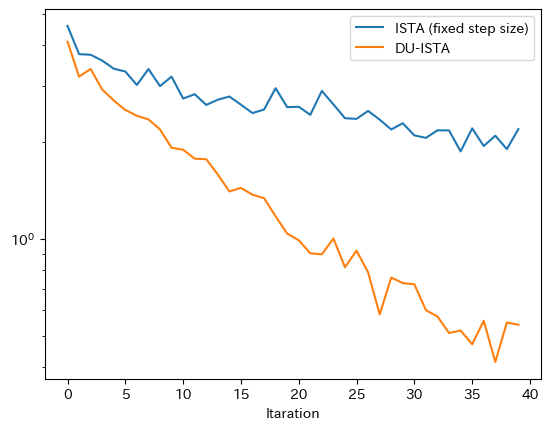

In [15]:
df.plot(df.columns[0], df.columns[1:3])
plt.yscale("log")

In [16]:
df["$\eta$"] = eta_trained.real
df["$\mu$"] = mu_trained.real

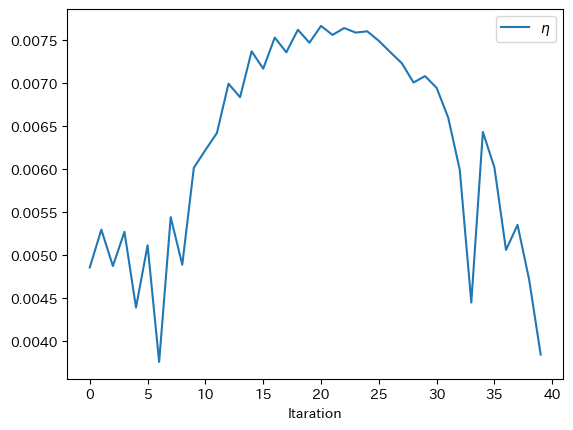

In [17]:
df.plot(df.columns[0], "$\eta$");

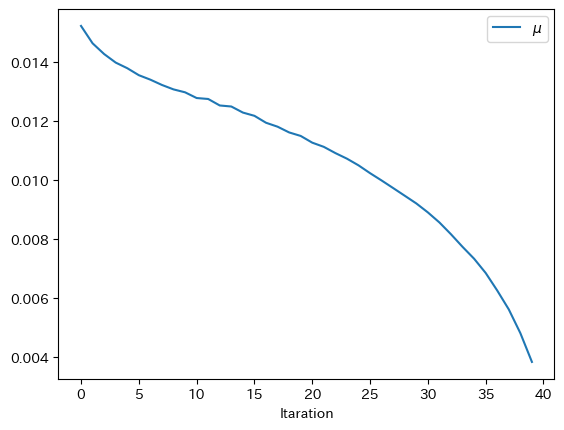

In [18]:
df.plot(df.columns[0], "$\mu$");

In [19]:
def gen_y(x):
    y = A @ x + sigma * jnp.array(np.random.randn(m))
    return y
batch_gen_y = jax.vmap(gen_y, in_axes=-1, out_axes=-1)

In [20]:
K = 1
seq = np.random.randn(n, K)
support = np.random.binomial(1,p,size=(n, K))
x = jnp.array(seq * support)
y = batch_gen_y(x)

In [21]:
df2 = pd.DataFrame()
df2["idx"] = range(n)
df2["grand truth"] = x

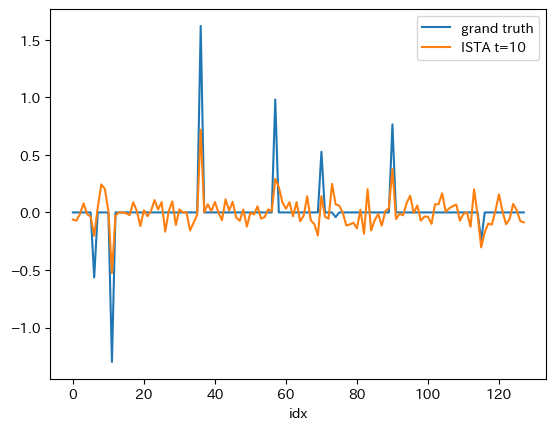

In [22]:
t = 10
df2["ISTA t={}".format(t)] = ISTA(t, y)
df2.plot("idx", ["grand truth", "ISTA t={}".format(t)]);

In [23]:
df3 = pd.DataFrame()
df3["idx"] = range(n)
df3["grand truth"] = x

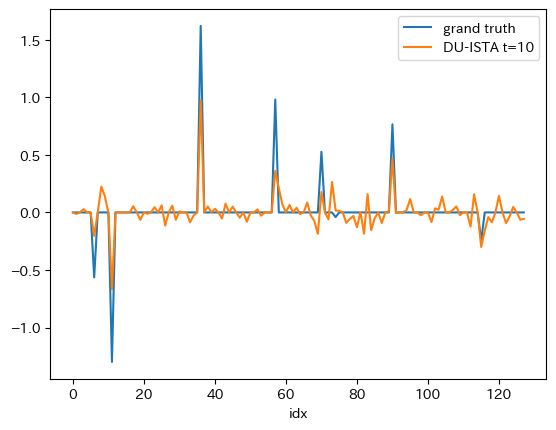

In [24]:
t = 10
df3["DU-ISTA t={}".format(t)] = DU_ISTA(t, y, eta_trained.real, mu_trained.real)
df3.plot("idx", ["grand truth", "DU-ISTA t={}".format(t)]);

In [25]:
df4 = pd.DataFrame()
df4["idx"] = range(n)
df4["grand truth"] = x

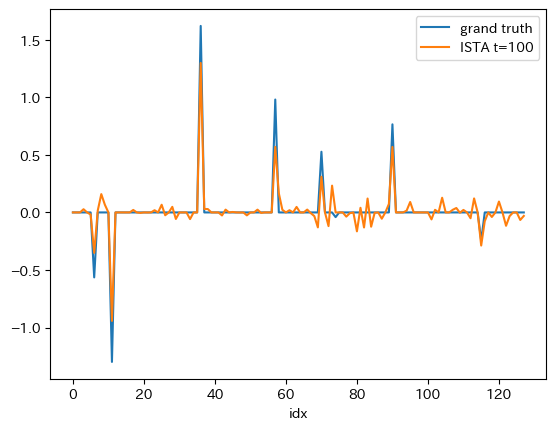

In [26]:
t = 100
df4["ISTA t={}".format(t)] = ISTA(t, y)
df4.plot("idx", ["grand truth", "ISTA t={}".format(t)]);

In [27]:
df5 = pd.DataFrame()
df5["idx"] = range(n)
df5["grand truth"] = x

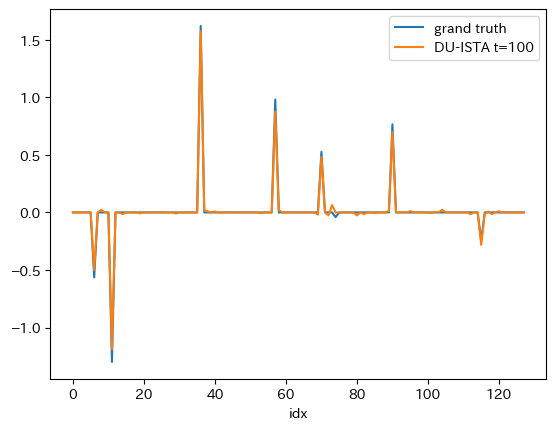

In [28]:
t = 100
df5["DU-ISTA t={}".format(t)] = DU_ISTA(t, y, eta_trained.real, mu_trained.real)
df5.plot("idx", ["grand truth", "DU-ISTA t={}".format(t)]);